# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 


## Import Packages

In [60]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


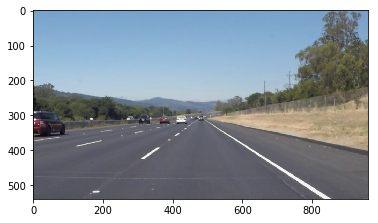

In [61]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [62]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def get_line_eqn(x1, y1, x2, y2):
    m = (y2-y1)/(x2-x1)
    b = y1 - m*x1
    return m, b

def draw_lines(img, lines, vertical_limits, color=(255, 0, 0), thickness=2, min_slope=0):
    if lines is None or not isinstance(vertical_limits, (tuple, list)):
        return

    # Group similar lines
    left_lane_lines = []
    right_lane_lines = []

    for line in lines:
        line = line[0]
        slope = get_line_eqn(*line)[0]
        if slope > min_slope:
            left_lane_lines.append(line)
        elif slope < -min_slope:
            right_lane_lines.append(line)

    # Average similar lines
    lane_lines = []
    if left_lane_lines:
        avg_left_lane_lines = np.mean(left_lane_lines, axis=0, dtype=int)
        lane_lines.append(avg_left_lane_lines)
    if right_lane_lines:
        avg_right_lane_lines = np.mean(right_lane_lines, axis=0, dtype=int)
        lane_lines.append(avg_right_lane_lines)

    # Extrapolate similar line
    extrapolated_lines = []
    y1, y2 = vertical_limits
    for lane_line in lane_lines:
        m, b = get_line_eqn(*lane_line)

        # This is to prevent divide-by-zero exception
        if m == 0:
            m = 0.0000001

        if m == float("Inf") or m == -float("Inf"):
            x1 = x2 = lane_line[0]
        else:
            x1 = (y1 - b) / m
            x2 = (y2 - b) / m
        extrapolated_lines.append(np.array([x1, y1, x2, y2], dtype=int))

    for line in extrapolated_lines:
        x1, y1, x2, y2 = line
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, vertical_limits):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, vertical_limits, min_slope=img.shape[0]/img.shape[1])
    return line_img


def weighted_img(img, initial_img, alpha=0.8, beta=1., gamma=0.):
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)


## Build a Lane Finding Pipeline



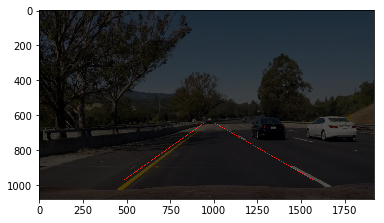

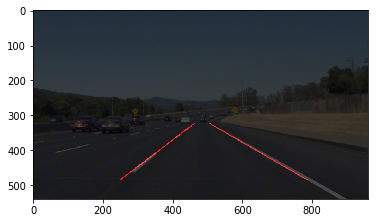

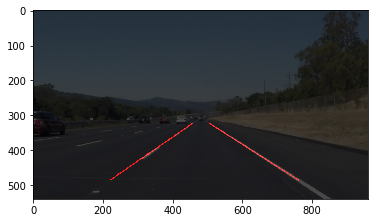

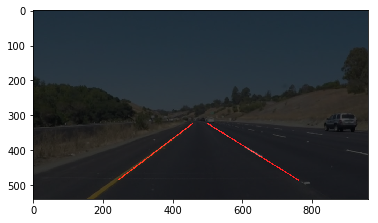

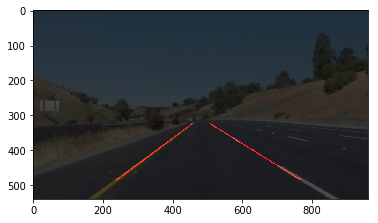

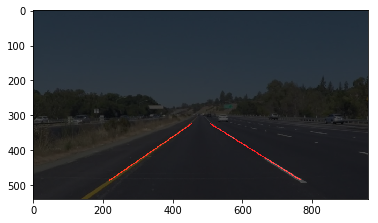

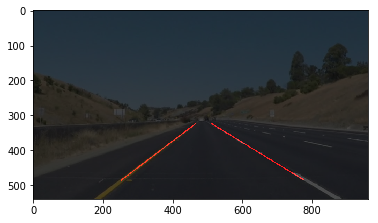

In [63]:
def lane_finding(raw_image):

    # Grayscale the image
    image = grayscale(raw_image)

    # Apply Gaussian blur
    image = gaussian_blur(image, 3)

    # Apply Canny filter
    image = canny(image, 30, 120)

    # Crop up the region of interest
    image_height, image_width = image.shape
    top_left = (0.46*image_width, 0.60*image_height)
    top_right = (0.51*image_width, 0.60*image_height)
    bottom_left = (0.2*image_width, 0.90*image_height)
    bottom_right = (0.88*image_width, 0.90*image_height)
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    image = region_of_interest(image, vertices)

    # Apply Hough Transform to get lanes
    rho = 2  # distance resolution in pixels of the Hough grid
    theta = np.pi * 1 / 180  # angular resolution in radians of the Hough grid
    threshold = 30  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30  # minimum number of pixels making up a line
    max_line_gap = 60  # maximum gap in pixels between connectable line segments
    image = hough_lines(image, rho, theta, threshold, min_line_length, max_line_gap,
                        vertical_limits=(bottom_left[1], top_left[1]))

    return image

test_image_files_dir = os.path.join(os.getcwd(), "test_images")
annotated_image_files_dir = os.path.join(os.getcwd(), "test_images_output")
if not os.path.exists(annotated_image_files_dir):
    os.makedirs(annotated_image_files_dir)
raw_image_files = os.listdir(test_image_files_dir)

for raw_image_file in raw_image_files:
    raw_image_full_path = os.path.join(test_image_files_dir, raw_image_file)
    annotated_image_full_path = os.path.join(annotated_image_files_dir, raw_image_file)

    raw_image = mpimg.imread(raw_image_full_path)
    annotated_image = lane_finding(raw_image)

    # Overlay the identified lanes on the original image
    overlay_image = weighted_img(annotated_image, raw_image, alpha=0.3, beta=1.0, gamma=0.2)
    plt.imshow(overlay_image)
    plt.savefig(annotated_image_full_path, bbox_inches="tight", frameon=False)
    plt.show()

## Test on Videos

In [64]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [65]:
def process_image(image):
    annotated_image = lane_finding(image)
    overlay_image = weighted_img(annotated_image, image, alpha=0.3, beta=1.0, gamma=0.2)
    return overlay_image

Let's try the one with the solid white lane on the right first ...

In [66]:
# Second, annotate videos
test_video_files_dir = os.path.join(os.getcwd(), "test_videos")
annotated_video_files_dir = os.path.join(os.getcwd(), "test_videos_output")
if not os.path.exists(annotated_video_files_dir):
    os.makedirs(annotated_video_files_dir)
raw_video_files = os.listdir(test_video_files_dir)

for raw_video_file in raw_video_files:
    raw_video_full_path = os.path.join(test_video_files_dir, raw_video_file)
    annotated_video_full_path = os.path.join(annotated_video_files_dir, raw_video_file)

    raw_video = VideoFileClip(raw_video_full_path)
    annotated_video = raw_video.fl_image(process_image)
    annotated_video.write_videofile(annotated_video_full_path, audio=False)


[MoviePy] >>>> Building video c:\Projects\Udacity\Term1\Lesson1\CarND-LaneLines-P1\test_videos_output\challenge.mp4
[MoviePy] Writing video c:\Projects\Udacity\Term1\Lesson1\CarND-LaneLines-P1\test_videos_output\challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:06<00:00, 41.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: c:\Projects\Udacity\Term1\Lesson1\CarND-LaneLines-P1\test_videos_output\challenge.mp4 

[MoviePy] >>>> Building video c:\Projects\Udacity\Term1\Lesson1\CarND-LaneLines-P1\test_videos_output\solidWhiteRight.mp4
[MoviePy] Writing video c:\Projects\Udacity\Term1\Lesson1\CarND-LaneLines-P1\test_videos_output\solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:02<00:00, 88.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: c:\Projects\Udacity\Term1\Lesson1\CarND-LaneLines-P1\test_videos_output\solidWhiteRight.mp4 

[MoviePy] >>>> Building video c:\Projects\Udacity\Term1\Lesson1\CarND-LaneLines-P1\test_videos_output\solidYellowLeft.mp4
[MoviePy] Writing video c:\Projects\Udacity\Term1\Lesson1\CarND-LaneLines-P1\test_videos_output\solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:08<00:00, 82.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: c:\Projects\Udacity\Term1\Lesson1\CarND-LaneLines-P1\test_videos_output\solidYellowLeft.mp4 

